In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('/home/helfrech/Tools/GCH/GCH')

# Maths
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# Plotting
import matplotlib.pyplot as plt

# Atoms
import ase.io as aseio

# ML
from regression import KPCovR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from kernels import center_kernel, center_kernel_fast
from kernels import center_kernel_oos, center_kernel_oos_fast
from gch_init import gch_init
from gch_run import gch_run

# Utilities
import h5py
import json
import subprocess
import glob
from copy import deepcopy
from project_utils import load_structures_from_hdf5

# SOAP
from soap import quippy_soap, librascal_soap

In /home/helfrech/.config/matplotlib/stylelib/cosmo.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/helfrech/.config/matplotlib/stylelib/cosmoLarge.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
#sys.path.append('/scratch/helfrech/Sync/GDrive/Projects/KPCovR/kernel-tutorials')
#from utilities.sklearn_covr.kpcovr import KernelPCovR as KPCovR2

# TODO: Build the (standard) GCH

In [4]:
# Load SOAP hyperparameters

In [5]:
# Load SOAPs

In [6]:
# Load projections to convert HDF5 to text so the GCH utility can load it

In [7]:
# Load sparse KPCA model (currently auto-centers, but this may change in the future)

In [8]:
# Prepare XYZ and properties

In [9]:
# Initialize GCH

In [10]:
# KPCA on shaken structures

In [11]:
# Run GCH

In [12]:
# Postprocessing

# Build a GCH based on KPCovR projections

In [13]:
gch_dir = './gchtmp_kpcovr'

In [14]:
cutoff = 6.0

In [15]:
component_idxs = np.loadtxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/FPS_components.idxs', 
                            usecols=0, dtype=np.int)

In [16]:
# Load SOAP hyperparameters
with open('../Processed_Data/soap_hyperparameters.json', 'r') as f:
    soap_hyperparameters = json.load(f)

centers = [14] # Center on Si, take Si and O in environment
soap_hyperparameters['component_idxs'] = component_idxs
soap_hyperparameters['interaction_cutoff'] = cutoff # TODO: change this to do 3.5 cutoff also

In [17]:
# Load IZA cantons to remove RWY
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]
cantons_iza = np.delete(cantons_iza, RWY)

In [18]:
# Load train kernel to center the rattled kernel
kernel_file = f'../Processed_Data/Models/{cutoff}/structure_kernels.hdf5'

f = h5py.File(kernel_file, 'r')

K_train = f['K_train'][:]
kernel_type = f.attrs['kernel_type']
gamma = f.attrs['gamma']

idxs_iza_train = f.attrs['idxs_iza_train']
idxs_iza_test = f.attrs['idxs_iza_test']
idxs_deem_train = f.attrs['idxs_deem_train']
idxs_deem_test = f.attrs['idxs_deem_test']

f.close()

In [19]:
# Load SOAPs
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps.hdf5'
deem_soaps = load_structures_from_hdf5(deem_file, datasets=None, concatenate=False)
deem_soaps = [deem_soaps[i] for i in idxs_deem_train]

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/soaps.hdf5'
iza_soaps = load_structures_from_hdf5(iza_file, datasets=None, concatenate=False)
iza_soaps.pop(RWY)
iza_soaps = [iza_soaps[i] for i in idxs_iza_train]

In [20]:
# Load projections to convert HDF5 to text so the GCH utility can load it
deem_file = f'../Processed_Data/DEEM_10k/Data/{cutoff}/kpcovr_structures.hdf5'
T_deem = load_structures_from_hdf5(deem_file, datasets=None, concatenate=True)

iza_file = f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/kpcovr_structures.hdf5'
T_iza = load_structures_from_hdf5(iza_file, datasets=None, concatenate=True)

np.savetxt(f'{gch_dir}/T.dat', np.vstack((T_iza, T_deem)))

In [21]:
# Unpickle the reference KPCovR model
kpcovr_file = f'../Processed_Data/Models/{cutoff}/kpcovr.json'

with open(kpcovr_file, 'r') as f:
    kpcovr_dict = json.load(f)        

# Turn lists into arrays
for k, v in kpcovr_dict.items():
    if isinstance(v, list):
        kpcovr_dict[k] = np.array(v)
        
kpcovr = KPCovR()
kpcovr.__dict__ = kpcovr_dict

In [22]:
# Load kernel parameters
model_file = f'../Processed_Data/Models/{cutoff}/volumes_mae_parameters.json'

with open(model_file, 'r') as f:
    model_dict = json.load(f)

kernel_type = model_dict['kernel_type']
gamma = model_dict['gamma']

In [23]:
# Concatenate IZA and DEEM xyz files
deem = aseio.read('../Raw_Data/GULP/DEEM_10k/DEEM_10000_OPT.xyz', index=':')
iza = aseio.read('../Raw_Data/GULP/IZA_226/IZA_OPT.xyz', index=':')
iza.pop(RWY) # All the IZA structures are in alphabetical order, so this should work
aseio.write(f'{gch_dir}/iza+deem.xyz', iza+deem, format='extxyz')

# Prepare energies
energies = []
volumes = []
for i in iza:
    energies.append(i.info['Energy_per_Si'])
    n_Si = np.count_nonzero(i.get_atomic_numbers() == 14)
    volumes.append(i.cell.volume / n_Si)

energy_errors = []
for d in deem:
    energies.append(d.info['Energy_per_Si'])
    energy_errors.append(d.info['Energy_per_Si'] - d.info['Energy_per_Si_Opt'])
    n_Si = np.count_nonzero(d.get_atomic_numbers() == 14)
    volumes.append(d.cell.volume / n_Si)

    
energies = np.asarray(energies)
energies -= np.mean(energies, axis=0)
energy_errors = np.asarray(energy_errors)
energy_rmse = np.sqrt(np.mean(energy_errors**2))
volumes = np.asarray(volumes)

np.savetxt(f'{gch_dir}/energies_per_si.dat', energies)

print(energy_rmse)

0.1732170741579647


In [28]:
# Compute cell uncertainty
orig_glob = sorted(glob.glob('../Raw_Data/GULP/IZA_226/Orig_cif_files.d/*.cif'))
opt_glob = sorted(glob.glob('../Raw_Data/GULP/IZA_226/Opt_cif_files.d/*.cif'))

# All the IZA structures are in alphabetical order, so this should work
orig_glob.pop(RWY)
opt_glob.pop(RWY)

cell_errors = []
for orig, opt in zip(orig_glob, opt_glob):
    orig_cif = aseio.read(orig)
    opt_cif = aseio.read(opt)
    cell_errors.append(np.linalg.norm(orig_cif.cell - opt_cif.cell)**2)
    
cell_errors = np.asarray(cell_errors)
cell_rmse = np.sqrt(np.mean(cell_errors))

print(cell_rmse)

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(74, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'triclinic' is not interpreted for space group 1. This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'cubic' is not interpreted for space group Spacegroup(229, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(63, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMEN

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'tetragonal' is not interpreted for space group Spacegroup(127, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(10, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(38, setting=1). This may result in wrong setting!
  setting_name, spacegroup))
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(65, setting=1). This may result in wrong setting!
  setting_name, spacegro

0.3166076535796065


/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'orthorhombic' is not interpreted for space group Spacegroup(66, setting=1). This may result in wrong setting!
  setting_name, spacegroup))


In [29]:
# Initialize GCH
pk = f'{gch_dir}/T.dat' # File containing the kernel (or projections)
pnrg = f'{gch_dir}/energies_per_si.dat' # File containing the energies
setxyz = f'{gch_dir}/iza+deem.xyz' # File containing the structures
wdir_local = f'{gch_dir}/rattled' # Directory in which to save the rattled reference structures
s_c = cell_rmse # Uncertainty in cell between structures
s_e = energy_rmse # Uncertainty in energy
ndim = 3 # GCH dimensions (includes energy)
numref = 100 # Number of reference structures
numshaken = 10 # Number of rattled structures per reference
conv = 0.20 # Convergence threshold: 100/conv hulls are constructed
mode = 'fps' # Selection mode for the reference structures
npca = None # Number of KPCA components: None for providing projections, <= 0 for taking all components

gch_init(pk, pnrg, setxyz, wdir_local, s_c, s_e, ndim, numref, numshaken, conv, mode, npca)

Loading the kernel matrix, it can take a minute if thousands of elements
/scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/./gchtmp_kpcovr/rattled
DONE: Loaded data
Initializing statistical sampling of the fuzzy GCH
Uncertainty in Cartesian positions 0.825586180848252
DONE ! go to /scratch/helfrech/Sync/GDrive/Projects/Zeolites_IZA-DEEM2/Scripts/./gchtmp_kpcovr/rattled/ to see what's in there


In [30]:
# Compute SOAPs for shaken structures
shaken_refs = aseio.read(f'{gch_dir}/rattled/shaketraj.xyz', index=':')

shaken_ref_soaps = librascal_soap(shaken_refs, centers, **soap_hyperparameters)

100%|██████████| 1100/1100 [00:26<00:00, 41.49it/s]


In [31]:
# Compute kernel for shaken structures
K_rattled = build_kernel(shaken_ref_soaps, iza_soaps+deem_soaps,
                         kernel=kernel_type, gamma=gamma)
Kc_rattled = center_kernel_fast(K_rattled, K_ref=K_train)

Kc_rattled /= np.trace(K_train) / K_train.shape[0]

100%|██████████| 1100/1100 [30:29<00:00,  1.66s/it]


In [32]:
# We initialize the GCH on all structures, but project the
# rattled structures using the same train set as was used to build
# the original KPCovR model
T_rattled = kpcovr.transform_K(Kc_rattled)
np.savetxt(f'{gch_dir}/rattled/T.dat', T_rattled)

In [33]:
T = np.loadtxt(f'{gch_dir}/T.dat')
ref_idxs = np.loadtxt(f'{gch_dir}/rattled/refstruct.idx', dtype=int)

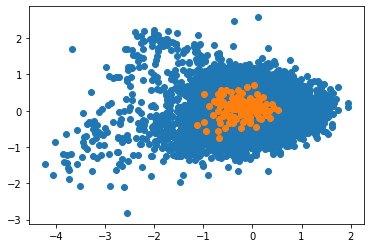

In [34]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T_rattled[:, 0], T_rattled[:, 1])
plt.show()

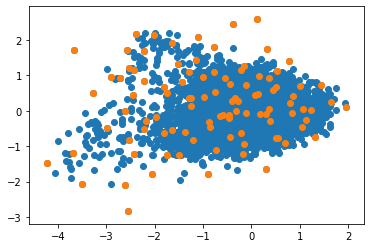

In [35]:
plt.scatter(T[:, 0], T[:, 1])
plt.scatter(T[ref_idxs, 0], T[ref_idxs, 1])
plt.show()

In [36]:
# Run GCH
shk = f'{gch_dir}/rattled/T.dat' # File containing the kernel (or projections) for the rattled structures
wdir = f'{gch_dir}/rattled' # Directory in which the rattled reference structures reside
mp = 0.99 # Cutoff probability for determining the GCH vertices
gch_run(shk, wdir, mp)

We will load both the dataset kernel and the shaken kernel, it could take some minutes in case of thousands of structures..
You have selected 500 convex hulls samples per pruning iterations
Statistical sampling of the fuzzy GCH
GCH construction :  2.241267204284668  sec
Single Hull construction during before pruning :  2.2221829891204834  sec
Iteration :  200  in  500
Iteration :  400  in  500
 Let's start pruning! 
printing rr_pfile.shape
(41, 7)
Iteration :  200  in  500
Iteration :  400  in  500
0.092
Pruning iter :  1  min prob:  0.092  # vertex :  41
printing rr_pfile.shape
(35, 7)
Iteration :  200  in  500
Iteration :  400  in  500
0.186
Pruning iter :  2  min prob:  0.186  # vertex :  35
printing rr_pfile.shape
(32, 7)
Iteration :  200  in  500
Iteration :  400  in  500
0.35
Pruning iter :  3  min prob:  0.35  # vertex :  32
printing rr_pfile.shape
(30, 7)
Iteration :  200  in  500
Iteration :  400  in  500
0.45
Pruning iter :  4  min prob:  0.45  # vertex :  30
printing rr_pfil

In [37]:
vprobprune = np.loadtxt(f'{gch_dir}/rattled/vprobprune.dat')
print(vprobprune.shape)

(14, 10225)


In [38]:
# Hull distances
gch_vertices = np.nonzero(vprobprune[-1])[0]
print(gch_vertices)

vertices = np.zeros(T.shape[0], dtype=int)
vertices[gch_vertices] = 1

e_gch = energies[gch_vertices]
T_gch = T[gch_vertices, :]

eT = np.hstack((e_gch[:, np.newaxis], T_gch))
eT_all = np.hstack((energies[:, np.newaxis], T))
vertex_hull = ConvexHull(eT[:, 0:ndim])

# Omit simplices on the "top" of the GCH
vertex_hull_facets = np.delete(vertex_hull.equations, 
                               np.nonzero(vertex_hull.equations[:, 0] > 0.0),
                               axis=0)

d = -(np.matmul(eT_all[:, 0:ndim], vertex_hull_facets[:, 0:-1].T) + vertex_hull_facets[:, -1])
de = -d / vertex_hull_facets[:, 0]
d = np.amin(np.abs(d), axis=1)
de = np.amin(np.abs(de), axis=1)

[  17   39   54   71   98  106  112  120  123  189  206  217 1051 1854
 2324 4517 5099 6090 7212 9833]


In [39]:
for i in range(0, np.amax(cantons_iza)):
    selection = np.nonzero(cantons_iza == i+1)
    print(np.mean(d[selection]), np.amin(d[selection]), np.amax(d[selection]), np.std(d[selection]))

0.8538377672344409 0.0 1.8530302419918987 0.47985719954704564
0.7184247352352916 0.0 1.9147915581445172 0.5107009894622317
0.7179219301717017 0.0 1.9638495419943431 0.5355178669481168


In [40]:
print(np.mean(d[0:225]), np.amin(d[0:225]), np.amax(d[0:225]), np.std(d[0:225]))
print(np.mean(d[225:]), np.amin(d[225:]), np.amax(d[225:]), np.std(d[225:]))

0.7393370257937188 0.0 1.9638495419943431 0.5160667285446535
1.0729322133997634 0.0 2.318749537095066 0.35781467492246144


In [41]:
for i in range(0, np.amax(cantons_iza)):
    selection = np.nonzero(cantons_iza == i+1)
    print(np.mean(de[selection]), np.amin(de[selection]), np.amax(de[selection]), np.std(de[selection]))

3.8769420190785095 0.0 11.942148207890945 2.5625511579780733
4.827729863196192 0.0 41.32899592341433 5.323351859458703
7.623304214435856 0.0 38.78565919470259 8.716813682588583


In [42]:
print(np.mean(de[0:225]), np.amin(de[0:225]), np.amax(de[0:225]), np.std(de[0:225]))
print(np.mean(de[225:]), np.amin(de[225:]), np.amax(de[225:]), np.std(de[225:]))

5.524714224708095 0.0 41.32899592341433 6.431756476411568
14.109861376364549 0.0 24.48846515895962 4.779412135314572


In [43]:
# Compute inverse distances
d_inv = np.log10(1.0/d)
de_inv = np.log10(1.0/de)

# Set inf distances to maximum non-inf distances
d_inv[np.isinf(d_inv)] = np.amax(np.delete(d_inv, np.nonzero(np.isinf(d_inv))))
de_inv[np.isinf(de_inv)] = np.amax(np.delete(de_inv, np.nonzero(np.isinf(de_inv))))

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


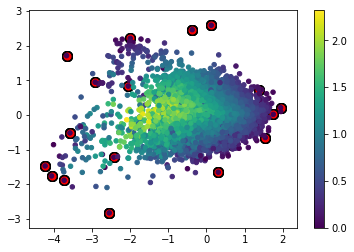

In [44]:
for vertex_simplex in vertex_hull.simplices:
    plt.scatter(T_gch[vertex_simplex, 0], T_gch[vertex_simplex, 1], c='k', s=100)
    
plt.scatter(T_gch[vertex_hull.vertices,0], T_gch[vertex_hull.vertices,1], c='r', s=50)
plt.scatter(T[:,0], T[:,1], c=d, cmap='viridis', s=20)
plt.colorbar()
plt.show()

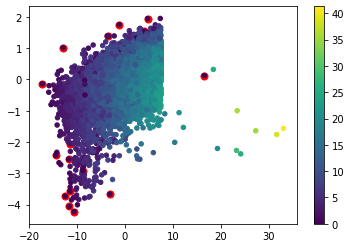

In [45]:
plt.scatter(eT_all[gch_vertices, 0], eT_all[gch_vertices, 1], c='r', s=50)
plt.scatter(eT_all[:,0], eT_all[:,1], c=de, cmap='viridis', s=20)
plt.colorbar()
plt.show()

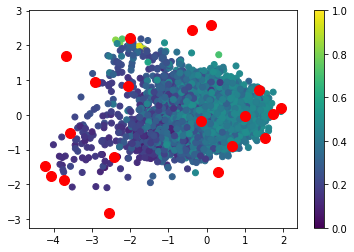

In [46]:
plt.scatter(T[:, 0], T[:, 1], c=energies, cmap='viridis')
plt.scatter(T[gch_vertices, 0], T[gch_vertices, 1], c='r', s=100)
plt.colorbar()
plt.show()

# Build a chemiscope

In [47]:
sys.path.append('/home/helfrech/Tools/chemiscope/utils')
from chemiscope_input import write_chemiscope_input

In [48]:
true_classes_iza = np.array([f'IZA{i}' for i in cantons_iza])
true_classes_deem = np.array(['DEEM']*len(deem))
true_classes = np.concatenate((true_classes_iza, true_classes_deem))

predicted_classes_iza = \
    np.loadtxt(f'../Processed_Data/IZA_226onDEEM_10k/Data/{cutoff}/kpcovr_structure_cantons.dat', dtype=int)
predicted_classes_deem = \
    np.loadtxt(f'../Processed_Data/DEEM_10k/Data/{cutoff}/kpcovr_structure_cantons.dat', dtype=int)
predicted_classes = np.concatenate((predicted_classes_iza, predicted_classes_deem))
predicted_classes = np.array([f'IZA{pc}' if pc < 4 else 'DEEM' for pc in predicted_classes])

In [49]:
frames = deepcopy(deem)
for frame in frames:
    for i in ('Energy_unit', 'spacegroup', 'Energy', 'unit_cell', 'Energy_per_Si_Opt'):
        frame.info.pop(i)

frames = iza + frames

extra = dict(projection=dict(target='structure', values=T[:, 0:2]),
             energies=dict(target='structure', values=energies),
             volumes=dict(target='structure', values=volumes),
             vertex=dict(target='structure', values=vertices),
             true_class=dict(target='structure', values=true_classes),
             predicted_class=dict(target='structure', values=predicted_classes),
             hull_distance=dict(target='structure', values=d),
             inv_hull_distance=dict(target='structure', values=d_inv),
             hull_distance_energy=dict(target='structure', values=de),
             inv_hull_distance_energy=dict(target='structure', values=de_inv))

In [51]:
write_chemiscope_input(f'{gch_dir}/svm-kpcovr-gch_chemiscope_test.json.gz', 
                       frames, 
                       extra=extra, 
                       meta=None, 
                       cutoff=None)